Firstly, we install the lightkurve package

In [ ]:
pip install lightkurve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 62.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 74.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 885.7/885.7 KB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.8 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=06dac954bdc58d87e535b28eca11ed2ec716d42a28ab1e979ac3ec7

Then we import all the necessary stuff from the packages 

In [ ]:
from lightkurve import search_targetpixelfile 
from lightkurve import TessTargetPixelFile
import lightkurve as lk
import numpy as np

Then, we select a star

In [ ]:
# Use TESS data. That's being updated regularly. Kepler is already well analysed 

# Downloading MAST data
# https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

# Look for nearby stars 
# MAST catalogs -> TESS CTL v8.01 -> Advanced Search
# Has 9.5 million records

# Narrow down the search as you like

# For example:
# T_eff = Temperature between 2000 and 3500
#         These are red dwarfs and tend to have rapidly orbiting planets
#         Which fits the 24 day time sampling rate of TESS

# Distance = Between 12 and 24 parsecs
#            Because we are not able to do the Kessel run in less than 12 

# Take the ID, e.g. 140206488

# Double-check in EXOMAST to see if a planet has already been found

# Put the name in MAST search and find TESS data  
# We can try to access this with search_targetpixelfile
# OR download the data to a local folder 

Optimised code 

(-3.0, 3.0)

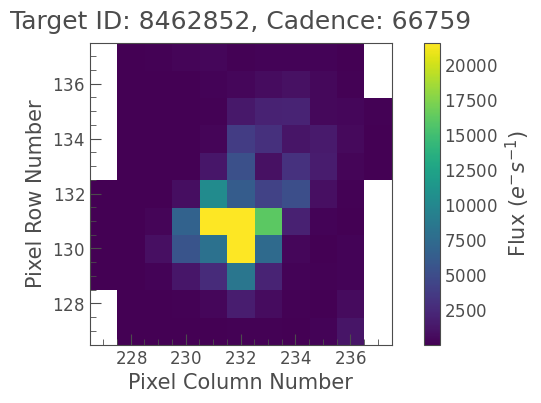

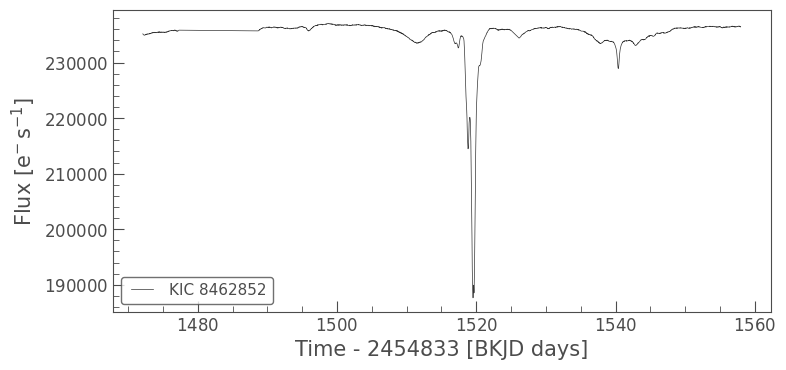

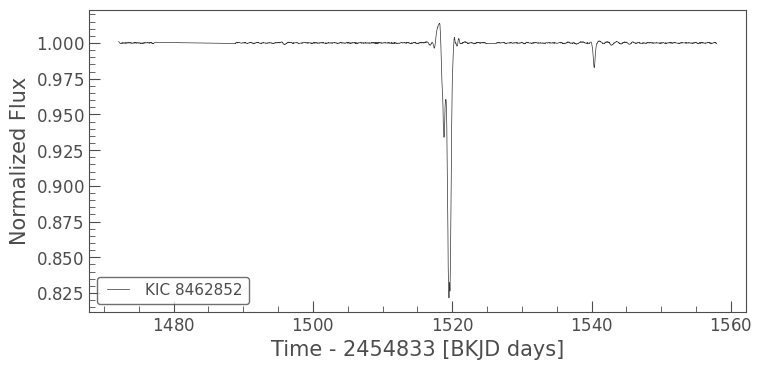

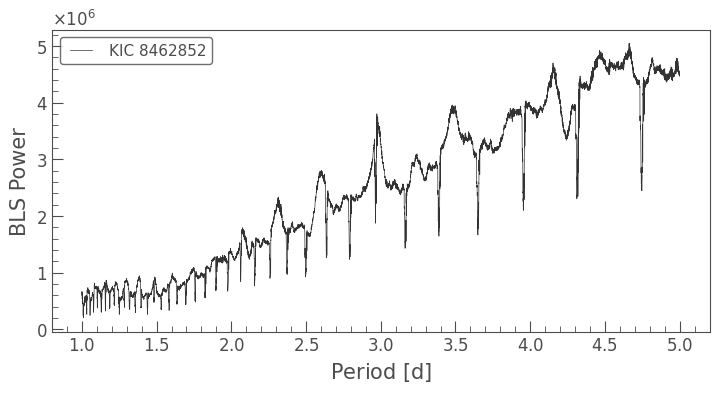

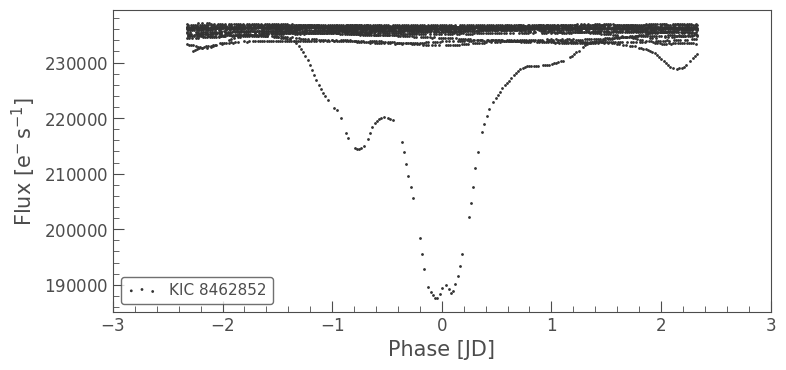

In [ ]:
# Let's download the pixelfile for a given star 
# And save it to a local folder (See download helper below)

# Command to search for file - often is not available, so that's why we download more manually
tpf = search_targetpixelfile("KIC 8462852", quarter=16).download(quality_bitmask='hardest');
#tpf = search_targetpixelfile('KIC 6922244', author="TESS", cadence="long", quarter=4).download()

#tpf = TessTargetPixelFile("/TESS/MAST_2023-02-15T0942/TESS/tess2021232031932-s0042-0000000405251343-0213-s/tess2021232031932-s0042-0000000405251343-0213-s_tp.fits")
# Show a single snapshot 
tpf.plot(frame=42)

# Plot the lightcurve
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

# Flatten it 
flat_lc = lc.flatten()
flat_lc.plot()

# Try and find the period of the most prominent orbiting object
period = np.linspace(1, 5, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

planet_x_period = bls.period_at_max_power
planet_x_t0 = bls.transit_time_at_max_power
planet_x_dur = bls.duration_at_max_power

# Phase-fold the ligthcurve based on the discovered period at max power
ax = lc.fold(period=planet_x_period, epoch_time=planet_x_t0).scatter()
ax.set_xlim(-3,3)

Download Helper

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

product_group_id = '96862624'
url = 'https://mast.stsci.edu/api/v0.1/Download/bundle.zip?previews=false&obsid=' + product_group_id
destination = '/TESS/'

download_and_unzip(url, destination)